# Football Win Probability Model

This tutorial is for creating a basic in-game win probability model for every NFL and College football game in 2017. In order to do this, the tutorial will guide you through scraping play by play data, applying a model to determine win probabilities, importing the data into a Pandas dataframe to visualize how certain plays affects the win probability, and then create a plot visualizing how win probabilities change during the course of the game.

The model we use here isn't necessarily a good one. Making the best model for win probability takes in a lot more predictor variables then we use here but this tutorial aims to demonstrate how to make a basic version of one. 

### Tutorial Content

In order to make a win probability model visualization, you must first scrape the data from the web, put the data in a pandas dataframe, apply the model, and then plot it. To do all this you will need to work with beautiful, pandas, matplotlib, scipy, and numpy.

We will be using espn.com to gather our data and throughout the tutorial I will be using the data from the 2018 Super Bowl (http://www.espn.com/nfl/playbyplay?gameId=400999173). 

Topics Covered:
* [Installing the Libraries](#Installing-the-Libraries)
* [Scraping the Data](#Scraping-the-Data)
* [Loading Data into Pandas Dataframe](#Loading-Data-into-Pandas-Dataframe)
* [Calculating Win Probabilities](#Calculating-Win-Probabilities)
* [Updating Pandas Dataframe](#Updating-Pandas-Dataframe)
* [Visualizing Win Probability](#Visualizing Win Probability)
* [Additional Resources](#Additional-Resources)

## Installing the Libraries


Before getting started on the win probability model, you need to install a couple of libraries that you will use. 

urllib is a standard library so you will not have to install it but to use BeautifulSoup, numpy, scipy, matplotlib, and pandas libraries you need to install them using pip.

    $ pip install beautifulsoup4
    
    $ pip install pandas
    
    >> python -m pip install --user numpy matplotlib scipy
   
After you run the installs, use the following commands below. 

In [134]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import scipy as scp
from scipy.stats import norm
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import re

## Scraping the Data

To get the information we need for an in-game win probability model, we need the play by play data of the game so that we can adjust the win probability as the game goes on. To do so, below, we create a function that returns a list with nested dictionaries that includes the information of each play. The relevant information we are looking for is, who the home and away team is, what their scores are, who currently has possession of the ball, how much time is left in the game, what down it is, how many yards they need until a first down, and lastly how many yards they need to cover total. 

Scraping data has a lot to do with traversing through the HTML and using their top-down design to access the information you are looking for. Essentially, there are categories and information stored in these and sub-categories that allows you to find and call them. To get the data we need we must do this to access specificaly what we want.

Here are the methods you will be using for this scraper:

###### 1. urlopen(url) and BeautifulSoup(html, "html.parser")

urlopen opens the url and returns a file-like object, in this case in the form of HTML. We then pass that result into BeautifulSoup() which gives us a Beautiful Soup object that we can now use to parse through the HTML.
    
###### 2. find_all() and find()

These are very similar methods. It finds the information you are looking for by passing in the type of element (ex. div, li, span) and identifying its attributes. For example, this line belows finds us the play by play table which is a div element with the id = "gamepackage-drives-wrap" that ESPN specified.  

    pbp = soup.find("div", {"id": "gamepackage-drives-wrap"})

The only difference between find_all() and find() is that find_all() returns a list of all elements of those specifications and find() gives you a specific instance. If that element cannot be found, it will return None, which is something we check for throughout the code.

###### 3. .text

This simply returns the text of a element as a string. You have to use these returned strings to access the data within the text that you need.

In the code, you must start from the most general element. In this case that was div element "gamepackage-drives-wrap" which is the segment that contained all the play by play data. From there, you access more specific elements within that, to get the data you need. For getting the information from the text, I use basic python methods to concatenate and index the string. Here is the function below that returns a list of dictionaries of all plays.

In [111]:
url = 'http://www.espn.com/nfl/playbyplay?gameId=400999173'

def pullplaybyplay(url):
    
    page = urlopen(url)
    soup = BeautifulSoup(page, "html.parser")
    pbp = soup.find("div", {"id": "gamepackage-drives-wrap"})

    pbplist = [] # initalizes list of dictionaries of plays
    who = ''
    homescore = 0
    hometeam = ''
    awayscore = 0
    awayteam = ''
    
    for li in pbp.find_all("li", class_ = 'accordion-item'): # each play is li element with class 'accordion-item'
        play = {}
        if li.find('span', {'class': 'home-logo'}) == None: # if the play doesn't specifiy home and away teams, ignore
            continue
        header = li.find('span', {'class': 'home-logo'})
        x = str(header.find('img')['src']) # get url of image

        # find who has ball for each drive, have to use URL of image 
        team = x.split("/")[-1].split(".")[0].upper() # this is the segment that specifies team 
        who = team # determines who has possession of the ball at the time

        # find scores of teams
        home = li.find('span', {'class': 'home'})
        hometeam = home.find('span', {'class':'team-name'}).text # get home team name
        ihomescore = int(home.find('span', {'class':'team-score'}).text) # get home team score
        away = li.find('span', {'class' : 'away'}) 
        awayteam = away.find('span', {'class':'team-name'}).text # get away team name
        iawayscore = int(away.find('span', {'class':'team-score'}).text) # get away team score

        for elem in li.find_all("li", class_ = ""):
            det = elem.find("h3").text # text gives part of the play by play info
            details = elem.find('span', {'class': 'post-play'}).text.strip() # gives other info of play 
            
            # find down number
            if det == '': continue
            down = int(det[0])
            det = det.split(" ")
            
            # find how many yards till first down
            if det[2] == 'Goal': ydstogo = int(det[5])
            else: ydstogo = int(det[2])
            
            # find quarter
            qtr = int(re.sub("\D", "", details[8:10])) #re.sub removes any elements that is not a number

            # find seconds left in the game
            timeLeft = details[1:6].strip()
            minute = int(re.sub("\D", "", details[1:3]))
            seconds = int(re.sub("\D", "", details[3:6]))
            timeSec = ((4 - qtr)*15 + minute)*60 + seconds
            
            # find yards until touchdown
            if len(det) == 5: # if at 50 yard line there is no team name so the list length is shorter
                ydsleft = int(det[4])
            else: # if not on 50 yard line
                if det[4] == who: ydsleft = 100 - int(det[5])
                else: ydsleft = int(det[5])
            
            # now store all of the information into the play dictionary witht these key names
            play['hometeam'] = hometeam
            play['homescore'] = homescore
            play['awayteam'] = awayteam
            play['awayscore'] = awayscore
            play['possession'] = who
            play['qtr'] = qtr
            play['timeLeft'] = timeLeft
            play['timeSec'] = timeSec
            play['down'] = down
            play['ydstogo'] = ydstogo
            play['ydsleft100'] = ydsleft
            pbplist.append(play.copy()) # append the play dictionary to the plays list
        homescore = ihomescore # increment the scores based on what happened during that drive
        awayscore = iawayscore
    return pbplist

In addition to scraping the play by play data, you must also scrape the Vegas line before the game starts. The vegas line gives you the predicted margin of victory of a team for that game. For example, if the line was "HOU - 10.0", that would mean Houston is predicted to win the game by 10 points before the game starts. You scrape this data, because again, you will need it for your model.

In [112]:
def pullvegasline(url):
    # change url so it is add the gamecast screen of espn where the desired info is
    u = url.index("nfl/") + 4
    r = url[u:].split("?")
    url = url[:u] + 'game?' + r[1]
    page = urlopen(url)
    soup = BeautifulSoup(page, "html.parser")
    line = soup.find('div', {'class':'odds-details'})
    vegas = line.find('li').text.split(" ")
    teamfavored, vegasline = vegas[1], vegas[2]
    return teamfavored, float(vegasline)

## Loading Data into Pandas Dataframe

Using the play by play data we scraped above, let's now store the information into a Pandas dataframe. The advantage of doing this is that now it is easier to access a certain type of data by using the column name and we can visualize the data of each play in a table. 

To do this, you simply use the pd.Dataframe() method in which you submit the list of dictionaries as the first parameter, and setting column names to 'header' which is the list of columns we want to display in the order that it is in, in the list. 

In [133]:
data = pullplaybyplay('http://www.espn.com/nfl/playbyplay?gameId=400999173')
header = ['hometeam','homescore', 'awayteam', 'awayscore', 'possession', 'qtr', 'timeLeft','timeSec', 'down', 'ydstogo', 'ydsleft100']
df = pd.DataFrame(data, columns = header)
df

,hometeam,homescore,awayteam,awayscore,possession,qtr,timeLeft,timeSec,down,ydstogo,ydsleft100
0,PHI,0,NE,0,PHI,1,14:54,3594,1,10,74
1,PHI,0,NE,0,PHI,1,14:20,3560,2,6,70
2,PHI,0,NE,0,PHI,1,13:37,3517,3,4,68
3,PHI,0,NE,0,PHI,1,13:12,3492,1,10,51
4,PHI,0,NE,0,PHI,1,12:36,3456,2,12,53
5,PHI,0,NE,0,PHI,1,12:30,3450,3,12,53
6,PHI,0,NE,0,PHI,1,11:47,3407,1,10,38
7,PHI,0,NE,0,PHI,1,11:07,3367,2,3,31
8,PHI,0,NE,0,PHI,1,10:29,3329,1,10,27
9,PHI,0,NE,0,PHI,1,9:51,3291,2,4,21


## Calculating Win Probabilities

Now that we have scraped the data, we can apply a model to calculate win probabilities while the game progresses. This model is going to depend on the vegas line, score differential, yards to go until a first down (ydstogo), yards to go until a touchdown (ydsleft100), quarter # (qtr), down # (down), and time remaining in seconds. I demonstrated these win probabilities using the 2018 Super Bowl data.

###  Win Probability Before Game

In a given NFL game, we use the model, that the final margin of victory is approximated as a normal random variable with the mean being the vegas line and the standard deviation of approximately 13.45. We will be using this information to calculate the win probability before game below. This probability will be in terms of the hometeam.

###### 1. Scipy method norm.cdf

This method allows you to apply a normal cdf distribution to find the win probability based on the vegas line. There are other methods like this in scipy such as pdf(), ppf(), etc. that you can use if you want to apply a different kind of distribution. The parameters you input here are 0.5 because you either win or you lose, loc = -vegline, and scale = 13.45 which defines the standard deviation. The norm.cdf() method will return the probability of getting the loc value given a normal distribution with the standard deviation given. 

In [135]:
url = 'http://www.espn.com/nfl/playbyplay?gameId=400999173'

def WPBG(url):
    vegas = pullvegasline(url)
    vegline = vegas[1]
    oneplay = pullplaybyplay(url)[0]
    hometeam = oneplay['hometeam'] # access who the home team is from the pandas dataframe with index of the column name
    
    # since you want the probability in terms of the home team you must know who the home team is
    # if its the away team you can just return the probability
    # else, you must take the probability and subtract it by 1 (general probability rules)
    if hometeam != vegas[0]: 
        winprob = norm.cdf(0.5, loc = -vegline, scale = 13.45)
    else: 
        winprob = 1 - norm.cdf(0.5, loc = -vegline, scale = 13.45)
    return winprob

### Win Probability in Game

Now, using the data that we pulled from the scraper, we update the win probabilities after every single play as the game progresses.

The model we use here to determine the win probabilities is one that I found online. Again, we use the scipy method norm.cdf().

        partone = (1 - norm.cdf(newmargin + 0.5, line, stdev)) + (0.5*norm.cdf(newmargin+0.5, line, stdev))
        parttwo = norm.cdf(newmargin - 0.5, line, stdev)
        winprob = partone - parttwo

You will be accessing the information you need for these calculations, which include homescore, awayscore, time left in seconds, total yards left, who has posssession, and who the home team really is. To explain, the expected points and epa variables below, essentially, expected points is another model that gives a prediction on how many points the team will score on a given position on the field. For example, if a team only has 1 yard to go until a touchdown their expected points is around 6, because they are so close to the touchdown. This decreases as you get further away. The EPA gives you the contribution of expected points on a given play. So as you progress forward, your EPA is positive and as you regress, your EPA is negative. You add this value to the current margin of the game to get the "new margin" which is the margin you use for these in game probabilities. 

You will use norm.cdf and other numpy methods for this function.

In [116]:
def ingameprob(url, team):
    playlist = pullplaybyplay(url) # get list of plays
    homevegline = WPBG(url) # get vegas line
    epprev = 0
    poss = ""
    winproblist = [] # initialize list of win probabilities, this length should equal length of the list of plays
    for play in playlist:
        homescore = play['homescore'] # access home team score from pandas dataframe
        awayscore = play['awayscore'] # access away team score from pandas dataframe
        differential = awayscore - homescore # our model inputs differential in terms of away team
        timeSec = play['timeSec'] # access time left in seconds from pandas dataframe
        stdev = 13.45 / (np.sqrt(3600/timeSec)) # sqrt() method finds the square root
        line = - homevegline * (timeSec/3600) # calculates updated line as timeSec decreases
        
        ydsleft = play['ydsleft100'] # access yards left to touchdown from pandas dataframe
        
        if poss != play['possession']:
            epprev = 0
        expectedpoints = 6.1 - 0.07508 * ydsleft # linear model for expected points
        epa = expectedpoints - epprev # subtract expected points by expected points of previous play to get EPA contribution
        
        poss = play['possession'] # access who has possession from pandas dataframe
        hometeam = play['hometeam'] # access hometeam name from pandas dataframe
        if poss == hometeam:
            newmargin = differential - epa
        else: 
            newmargin = differential + epa # calculates the 'new margin' we discussed based on who the home team is
        
        # this is the win probability model we are using 
        partone = (1 - norm.cdf(newmargin + 0.5, line, stdev)) + (0.5*norm.cdf(newmargin+0.5, line, stdev))
        parttwo = norm.cdf(newmargin - 0.5, line, stdev)
        winprob = partone - parttwo
        epprev = expectedpoints
        winproblist.append(np.ceil(winprob*10000)/10000) # round to 4 decimal points, np.ceil() finds ceiling of the float
    
    # again, since win probabilities are in terms of home team here, if the team specified is away you must subtract by one
    if team == 'home': pass
    else:
        for j in range(0, len(winproblist)):
            winproblist[j] = 1- winproblist[j]
    return winproblist

### Update Pandas Dataframe

We now update the pandas dataframe that we had before of the play by play, and put a new column that shows the win probabilities. The purpose is so that you can see side by side how certain plays with the time remaining, yds to go,etc, effects the probability of a team winning a game.

To do this you simply, index the dataframe with the column name desired, and set it equal to the list that you want to display. When doing this in general, you must make sure that the length of the added list is equal to the length of the number of rows in the dataframe. 

In [136]:
winp = ingameprob(url, 'home')
df['winprob'] = winp
df

,hometeam,homescore,awayteam,awayscore,possession,qtr,timeLeft,timeSec,down,ydstogo,ydsleft100,winprob
0,PHI,0,NE,0,PHI,1,14:54,3594,1,10,74,0.2640
1,PHI,0,NE,0,PHI,1,14:20,3560,2,6,70,0.2534
2,PHI,0,NE,0,PHI,1,13:37,3517,3,4,68,0.2468
3,PHI,0,NE,0,PHI,1,13:12,3492,1,10,51,0.2977
4,PHI,0,NE,0,PHI,1,12:36,3456,2,12,53,0.2335
5,PHI,0,NE,0,PHI,1,12:30,3450,3,12,53,0.2403
6,PHI,0,NE,0,PHI,1,11:47,3407,1,10,38,0.2919
7,PHI,0,NE,0,PHI,1,11:07,3367,2,3,31,0.2648
8,PHI,0,NE,0,PHI,1,10:29,3329,1,10,27,0.2547
9,PHI,0,NE,0,PHI,1,9:51,3291,2,4,21,0.2619


## Visualizing In-Game Win Probability

This is what it all comes down to. This section guides you in how to plot the win probabilities against the time remaining in the game to visualize how the win probability changes as the game progresses.

Here you will be using these methods.

###### 1. plt.plot()

This method is what plots the data. You give the parameters of the explanatory variable first and then the response variable. In this case the explanatory is time remaining and the response is the win probability. 

###### 2. plt.yticks() and plt.xtick()

Initially plt.plot() plots the data with the ticks on the axes that it decides. If you want to add ticks so that you can better see what the win probabilities are, you use these. You give it a list of numbers that you want as ticks.

###### 3. np.arrange()

This returns a list of numbers based on the start of the interval, the end, and the increments you want between the,.

###### 4. plt.xlabel() and plt.ylabel()

This labels the axes with what you want it to be called. There are optional parameters you can insert here such as fontsize. 

###### 5. plt.figure()

This sets the size of the plot, so that you can define the ratio of width and height that you want, and how big of a plot you want to see. 

###### 5. plt.grid() and plt.show()

plt.grid() simply puts gridlines on the plot and plt.show() displays the plot so that the user can visualize it. 

In [ ]:
def plotWinProb(url, team):
    w = ingameprob(url, team)
    data = pullplaybyplay(url)
    header = ['hometeam','homescore', 'awayteam', 'awayscore', 'possession', 'qtr', 'timeLeft','timeSec', 'down', 'ydstogo', 'ydsleft100']
    df = pd.DataFrame(data, columns = header)
    times = df['timeSec'].tolist()
    times.insert(0, 3600) # insert 3600 into 0th index, this indicates before the game starts
    x = WPBG(url).copy()
    w.insert(0, x) # insert probability of game before game starts at 0th index
    temptimes = []

    for time in times: # we do this so we can see graph as game progresses, not the other way around
        temptimes += [3600 - time]

    x = np.array(temptimes) # sets temptimes and w as arrays that can be used for plotting
    # if you would just insert temptimes and w as is, you will face an error
    y = np.array(w)

    fig = plt.figure(figsize = (20, 10)) # set size and ratio of plot
 
    plt.plot(x, y) 
    plt.yticks(np.arange(0, 1.05, step = 0.05))
    plt.xticks(np.arange(0, 3800, step = 200))
    plt.xlabel('Time in Seconds', fontsize = 16)
    plt.ylabel("Win Probability", fontsize = 16)
    
    if team == 'home': tm = df['hometeam'][0]
    else: tm = df['awayteam'][0]
    plt.title("In Game Win Probability for " + tm, fontsize = 24, fontweight = 'bold') # sets title
    plt.grid()
    plt.show()

Now let's display the plots for both the home and away team.

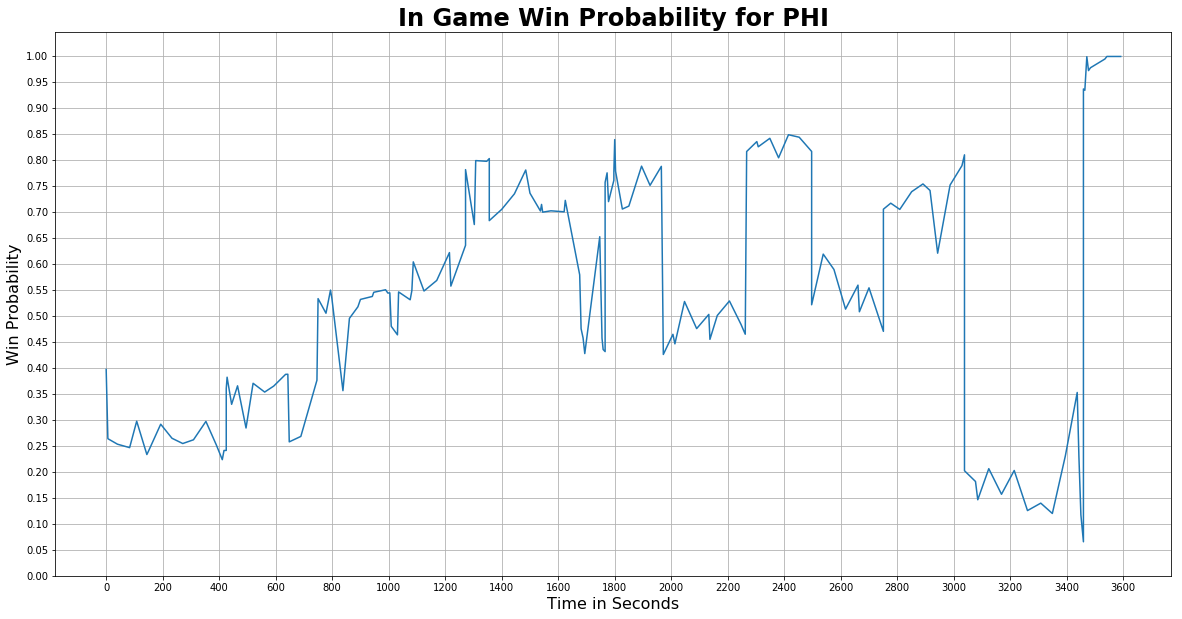

In [137]:
plotWinProb('http://www.espn.com/nfl/playbyplay?gameId=400999173', 'home')

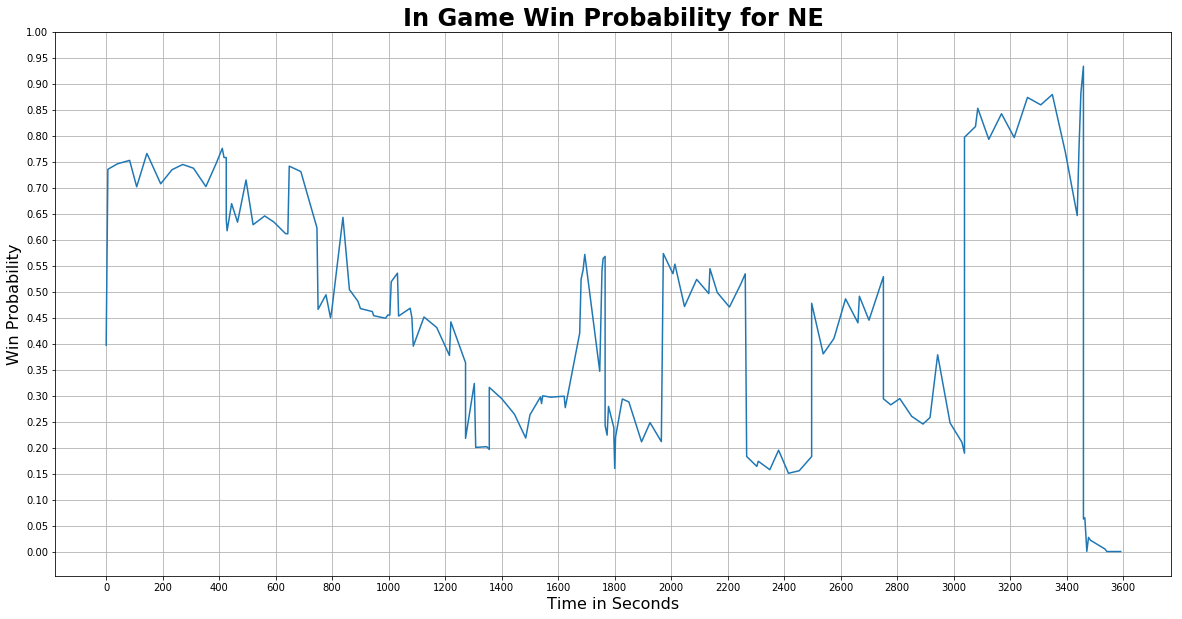

In [130]:
plotWinProb('http://www.espn.com/nfl/playbyplay?gameId=400999173', 'away')

## Additional Resources

You can do a lot more with the libraries that we used in this tutorial. They are powerful tools that can be applied to many more applications. Here are the links for more information about these libraries. I've also included the website to the win probability model that I used so you can see how they arrived at the model and to make sense of why we did certain calculations in that section of the tutorial. 

1. Numpy and SciPy :  https://docs.scipy.org/doc/
2. Pandas : https://pandas.pydata.org/pandas-docs/stable/
3. Matplotlib: https://matplotlib.org/contents.html
4. BeautifulSoup: https://www.crummy.com/software/BeautifulSoup/bs4/doc/
5. Win Probability Model: https://www.pro-football-reference.com/about/win_prob.htm